## 4.1 선형 회귀

### 4.1.1 정규방정식 Normal Equation

In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

In [2]:
import numpy as np

X = 2 * np.random.rand(100,1)

y = 4 + 3 * X + np.random.randn(100,1)

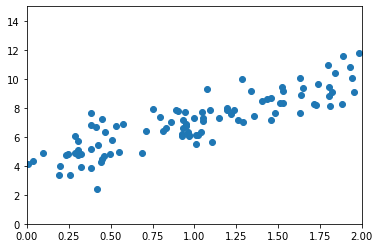

In [3]:
plt.scatter(X, y)
plt.axis([0, 2, 0, 15])
plt.show()

정규방정식을 사용해 $\hat{\theta}$ 를 계산해 보자.

역행렬 -> 행렬의 내적 곱셈

np.linalg.inv(), np.dot()

In [4]:
X_b = np.c_[np.ones((100, 1)), X]

theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)

In [5]:
theta_best

array([[4.01315263],
       [3.03972895]])

In [6]:
X_new = np.array([[0], [2]])

X_new_b = np.c_[np.ones((2, 1)), X_new]

y_predict = X_new_b.dot(theta_best)

y_predict

array([[ 4.01315263],
       [10.09261054]])

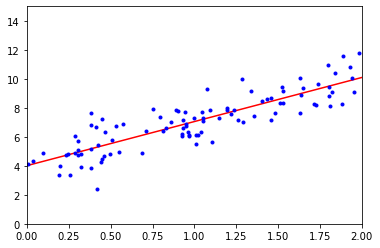

In [7]:
plt.plot(X_new, y_predict, 'r-')
plt.plot(X, y, "b.")
plt.axis([0, 2, 0, 15])
plt.show()

같은 동작을 하는 사이킷런 코드는 다음과 같습니다.

In [8]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()

lin_reg.fit(X, y)

lin_reg.intercept_, lin_reg.coef_

/data/data/com.termux/files/usr/lib/python3.8/site-packages/sklearn/externals/joblib/_multiprocessing_helpers.py:28: UserWarning: This platform lacks a functioning sem_open implementation, therefore, the required synchronization primitives needed will not function, see issue 3770..  joblib will operate in serial mode
  warnings.warn('%s.  joblib will operate in serial mode' % (e,))


(array([4.01315263]), array([[3.03972895]]))

In [9]:
lin_reg.predict(X_new)

array([[ 4.01315263],
       [10.09261054]])

### 4.1.2 계산 복잡도

정규 방정식은 $(n+1)\times(n+1)$ 크기가 되는 ${X^t}\cdot{X}$의 역행렬을 계산합니다.

계산 복잡도 computational complexity는 일반적으로 $O(n^{2.4})$에서 $O(n^3)$ 사이입니다.

특성 수가 매우 많아지면 정규방정식이 매우 느려집니다.

다른 방법으로 선형 회귀 모델을 훈련시켜 보겠습니다.

## 4.2 경사 하강법

step의 크기가 중요하다. learning rate 하이퍼파라미터로 결정된다.

학습률이 너무 작으면 시간이 오래 걸리고, 학습률이 너무 크면 발산하게 만들 수 있다.

경사하강법의 문제점 중 하나는 local minimum에 수렴하는 경우이다. 

다행히 선형회귀를 위한 MSE 비용함수는 convex function볼록함수 이다. 연속된 함수이며 기울기가 갑자기 변하지 않는다.

따라서 학습률이 너무 높지 않고 충분한 시간이 주어지면 global minimum에 접근할 수 있음을 보장한다.

### 4.2.1 배치 경사 하강법

편도함수partial derivative

비용함수의 모든 방향의 편도함수를 담은 그래디언트 벡터를 표현한다.

In [10]:
eta = 0.1 # 학습률
n_iterations = 1000
m = 100

theta = np.random.randn(2, 1)

for iteration in range(n_iterations):
    gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
    theta = theta - eta * gradients

In [11]:
theta

array([[4.01315263],
       [3.03972895]])

### 4.2.2 확률적 경사 하강법

샘플에 대한 그래디언트를 계산.

장점
- 매 반복에서 매우 적은 데이터만 처리하기 때문에 알고리즘이 훨씬 빠르다.
- local minimum 문제를 벗어나게 해 준다.

단점
- 불안정하다.
- global minimum에 다다르지 못하는 문제가 있다.
  - 학습률을 ㄹ점진적으로 감소시키는 방법으로 문제를 완화한다.
  - 학습 스케줄learning schedule을 적절하게 결정해야 하는 문제가 발생한다.

In [12]:
n_epochs = 50
t0, t1 = 5, 50 # learning schedule hyperparameter

def learning_schedule(t):
    return t0 / (t + t1)

theta = np.random.randn(2,1)

for epoch in range(n_epochs):
    m = 100
    for i in range(m):
        random_index = np.random.randint(m)
        xi = X_b[random_index:random_index+1]
        yi = y[random_index:random_index+1]
        gradient = 2 * xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(epoch * m + i)
        theta = theta - eta * gradients

In [13]:
theta

array([[ 0.66834166],
       [-1.74786402]])

사이킷런에서 SGD 방식으로 선형 회귀를 사용하려면 기본값으로 MSE를 최적화하는 SGDRegressor 클래스를 사용합니다.

다음 코드는 eta0=0.1, penalty=None을 사용해 epoch를 50번 수행합니다.

In [14]:
from sklearn.linear_model import SGDRegressor

sgd_reg = SGDRegressor(max_iter=50, penalty=None, eta0=0.1)

sgd_reg.fit(X, y.ravel())

SGDRegressor(alpha=0.0001, average=False, epsilon=0.1, eta0=0.1,
       fit_intercept=True, l1_ratio=0.15, learning_rate='invscaling',
       loss='squared_loss', max_iter=50, n_iter=None, penalty=None,
       power_t=0.25, random_state=None, shuffle=True, tol=None, verbose=0,
       warm_start=False)

In [15]:
sgd_reg.intercept_, sgd_reg.coef_

(array([4.06340938]), array([3.09086553]))

### 4.2.3 미니 배치 경사 하강법Mini-batch Gradient Descent

미니 배치라 부르는 임의의 작은 샘플에 대해서 그래디언트를 계산

미니배치를 어느 정도 크게 하면 SGD보다 덜 불규칙하게 움직인다.

장점
- 행렬 연산에 최적화된 하드웨어(GPU)를 사용해서 얻는 성ㄴ으 향상
- SGD에 비해 최솟값에 더 가깝게 도달할 수 있다.

단점
- local minimum에서 빠져나오는 것이 어려울 수 있다.

## 4.3 다항 회귀Polynomial Regression

In [16]:
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 0.5 * X**2 + X + 2 + np.random.randn(m, 1)

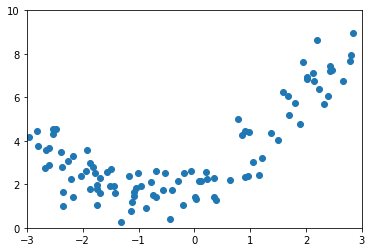

In [17]:
plt.scatter(X, y)
plt.axis([-3, 3, 0, 10])
plt.show()

In [18]:
from sklearn.preprocessing import PolynomialFeatures

poly_features = PolynomialFeatures(degree=2, include_bias=False)

X_poly = poly_features.fit_transform(X)

X[0]

X_poly[0]

array([-1.01262991,  1.02541934])

class sklearn.preprocessing.PolynomialFeatures(degree=2, interaction_only=False, include_bias=True, order='C')[source](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html?highlight=polynomialfeatures)
- Generate polynomial and interaction features.

- Generate a new feature matrix consisting of all polynomial combinations of the features with degree less than or equal to the specified degree. For example, if an input sample is two dimensional and of the form [a, b], the degree-2 polynomial features are [1, a, b, a^2, ab, b^2].

X_poly는 이제 원래 특성 X와 이 특성의 제곱을 포함한다. 이 확장된 훈련 데이터에 LinearRegression을 적용해 보자.

In [19]:
lin_reg = LinearRegression()

lin_reg.fit(X_poly, y)

lin_reg.intercept_, lin_reg.coef_

(array([2.02609798]), array([[0.88525404, 0.54288699]]))

In [20]:
X_new = np.linspace(-3, 3, 100).reshape(100, 1)
X_new_poly = poly_features.transform(X_new)
y_new = lin_reg.predict(X_new_poly)

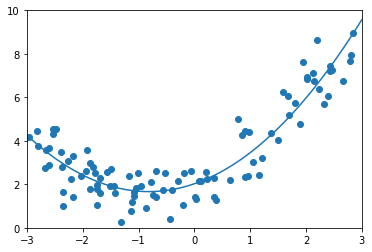

In [21]:
plt.scatter(X, y)
plt.plot(X_new, y_new)
plt.axis([-3, 3, 0, 10])
plt.show()

## 4.4 학습 곡선

모델이 복잡하면 과대적합이 되고 지나치게 단순하면 과소적합된다.

얼마나 복잡한 몯ㅔㄹ을 사용할 지 어떻게 결정할가? 어떻게 모델이 데이터에 과대적합, 과소적합되었는지 알 수 있을까?

교차검증 
- 훈련 뎅ㅣ터에서 성능이 좋지만 교차검증 점수가 나쁘면 모델이 과대적합된 것이다.
- 양쪽에 좋지 않으면 과소적합이다.

학습 곡선
- 훈련세트와 검증세트의 모델 성능을 훈련 세트 크기의 함수로 나타낸다.

In [22]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

def plot_learning_curves(model, X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
    train_errors, val_errors = [], []
    for m in range(1, len(X_train)):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
        val_errors.append(mean_squared_error(y_val, y_val_predict))
    plt.axis([0, 80, 0, 5])
    plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train set")
    plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="validation set")
    plt.legend(loc="upper right")

선형 회귀 모데ㄹ의 러닝 커브를 그려보자

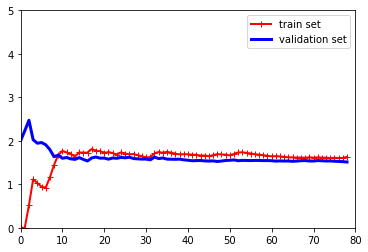

In [23]:
lin_reg = LinearRegression()
plot_learning_curves(lin_reg, X, y)

다음은 2차함수, 10차함수의 ㄹㄴㅣㅇ커브이다.

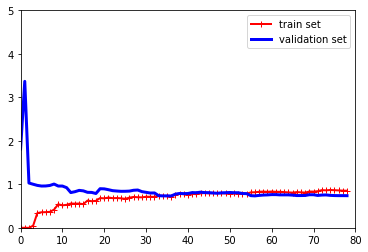

In [24]:
from sklearn.pipeline import Pipeline

polynomial_regression = Pipeline([
    ("poly_features", PolynomialFeatures(degree=2, include_bias=False)),
    ("lin_reg", LinearRegression()),
])

plot_learning_curves(polynomial_regression, X, y)

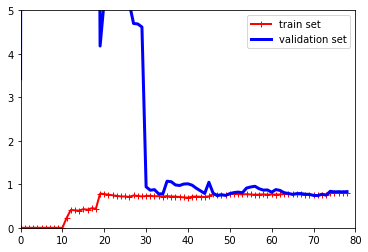

In [25]:
from sklearn.pipeline import Pipeline

polynomial_regression = Pipeline([
    ("poly_features", PolynomialFeatures(degree=10, include_bias=False)),
    ("lin_reg", LinearRegression()),
])

plot_learning_curves(polynomial_regression, X, y)

선형회귀와 다항회귀의 학습 곡선의 차이점
- 훈련 데이터의 오차가 선형 회귀모델보다 훨씬 낮다.
- 두 곡선 사이의 공간이 있다. 과대적합을 의미한다.

## 4.5 규제가 있는 선형 모델

### 4.5.1 릿지 회귀

In [26]:
from sklearn.linear_model import Ridge

ridge_reg = Ridge(alpha=1, solver="cholesky")
ridge_reg.fit(X, y)
ridge_reg.predict([[1.5]])

array([[4.95138585]])

다음은 SGDRegressor를 사용합니다. penalty="l2"는 SGD가 비용함수에 가중치 벡터의 l2 norm의 제곱을 2로 나눈 규제항을 추가하게 만든다. 즉 릿지 회귀와 같습니다.

In [27]:
sgd_reg = SGDRegressor(max_iter=5, penalty="l2")
sgd_reg.fit(X, y.ravel())
sgd_reg.predict([[1.5]])

array([3.81937136])

### 4.5.2 라쏘 회귀 Least Absolute Shrinkage and Selection Operator(Lasso)

릿지 회귀처럼 비용 함수에 규제항을 더하지만, l2 norm의 제곱을 2로 나눈 것 대신 가중치 벡터의 l1 norm을 사용한다.

라쏘 회귀의 중요한 특징은 덜 중요한 특성의 가중치를 완전히 제거하려고 한다는 점이다.

다시 말해 라쏘 회귀는 자동으로 특성 선택을 하고 희소 모델sparse model을 만든다.

### 4.5.3 엘라스틱넷ElasticNet

### 4.5.4 조기 종료early stopping

검증 에러가 최소에 도달하는 즉시 훈련ㅇ르 멈추는 것이다. 이 규제 테크닉은 매우 효과적이고 간단해서 훌륭한 공짜점심beautiful free lunch라고 불렀습니다.

## 4.6 로지스틱 회귀Logistic Regression

분류에 사용하는 회귀 알고리즘

### 4.6.1 확률 추정

입력 특성의 가 중치 합을 계산(그리고 편향을 더함) 그 결과값의 logistic을 출력

로지스틱은 0과 1 사이의 값을 출력하는 sigmoid function이다.

$\sigma(t) = \frac {1} {1+e^{-t}}$

로지스틱 회귀 모델은 $\theta^{t} \cdot x$가 양수일 때 1로 예측하고, 음수일 때 0으로 예측한다.

### 4.6.2 훈련과 비용 함수

$c(\theta)\begin{cases}-log(\hat{p})&&\mbox{y=1}일 때\\-log(1-\hat{p})&&\mbox{y=0}일 때\end{cases}$


전체 훈련 세트에 대한 비용 함수는 모든 훈련 샘플의 비용을 평균한 것이다. 이를 로그 손실log loss이라 한다.

### 4.6.3 결정 경계

In [28]:
from sklearn import datasets
iris = datasets.load_iris()

list(iris.keys())

/data/data/com.termux/files/usr/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:17: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.9 it will stop working
  from collections import Mapping, defaultdict


['data', 'target', 'target_names', 'DESCR', 'feature_names']

In [33]:
X = iris["data"][:, 3:] #꽃잎의 너비
y = (iris["target"] == 2).astype(np.int) # 1 Iris-Virginica면 1, 그렇지 않으면 0

In [34]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression()
log_reg.fit(X, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

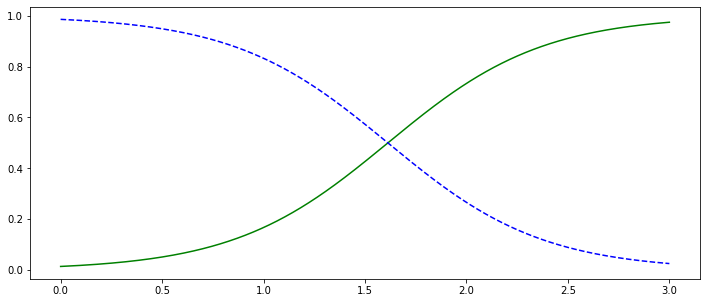

In [38]:
X_new = np.linspace(0, 3, 1000).reshape(-1, 1)
y_proba = log_reg.predict_proba(X_new)

plt.figure(figsize=(12,5))
plt.plot(X_new, y_proba[:, 1], "g-", label="Iris-Virginica")
plt.plot(X_new, y_proba[:, 0], "b--", label="not Iris-Virginica")

1.6cm 경계에서 decision boundary가 만들어진다.

In [44]:
log_reg.predict([[1.7], [1.5]])

array([1, 0])

### 4.6.4 소프트맥스 회귀Softmax Regression

다항 로지스틱 회귀Multinomial Logistic Regression 이라고도 한다.

소프트맥스 함수는 각 점수에 지수함수를 적용한 후 정규화한다. (모든 지수 함수의 결과의 합으로 나눈다.)

모델 추정은 크로스 엔트로피cross entropy 비용 함수를 최소화 하는 모델을 찾는다.

In [45]:
X = iris["data"][:, (2,3)]
y = iris["target"]

softmax_reg = LogisticRegression(multi_class="multinomial", solver="lbfgs", C=10)
softmax_reg.fit(X, y)

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=1, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

In [47]:
softmax_reg.predict([[5, 2]])

array([2])

In [48]:
softmax_reg.predict_proba([[5, 2]])

array([[6.33134078e-07, 5.75276066e-02, 9.42471760e-01]])